In [27]:
# Imports
import numpy as np 
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Response Encodings
CLASS_NVC = -1
CLASS_VC = 1

def map_to_class(stat_cc):
    if stat_cc < 5: # Violent
        return CLASS_VC
    elif stat_cc < 8: # Non-violent
        return CLASS_NVC
    else: # Unknown or nan
        return np.NaN

In [9]:
# Read in data
data = pd.read_csv("../../data/RPD_crime2011toNow.csv", sep=",")
label = "Statute_CrimeCategory"
df_xyl = data[["X", "Y"]]
df_xyl["class"] = data[label].apply(map_to_class) 

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [10]:
    # Remove rows with NAs
    null_rows = df_xyl.isnull().any(axis=1)
    print("Dropping %d rows with null (X,Y,Label) values" %sum(null_rows))
    df_cleaned_xy = df_xyl[list(map(lambda x: not x, null_rows))]

Dropping 450 rows with null (X,Y,Label) values


In [11]:
# Separate based on class
nvc_idx = df_cleaned_xy.index[df_cleaned_xy["class"] == CLASS_NVC]
vc_idx = df_cleaned_xy.index[df_cleaned_xy["class"] == CLASS_VC]
df_nvc = df_cleaned_xy.loc[nvc_idx]
df_vc = df_cleaned_xy.loc[vc_idx]

# Setup city grid
extreme_vals = lambda X: (X.min(), X.max())
xmin, xmax = extreme_vals(data["X"])
ymin, ymax = extreme_vals(data["Y"])
xgrid, ygrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
xygrid = np.vstack([xgrid.ravel(), ygrid.ravel()])

In [12]:
# Run KDE on each class
preds = []
classes = [df_nvc, df_vc]

for class_df in classes:
    crime_locs = np.vstack([class_df["X"], class_df["Y"]])

    # Compute KDE (using RBF kernel for now)
    kde = stats.gaussian_kde(crime_locs)

    # "Predict" on the grid
    kde_pred = np.reshape(kde(xygrid).T, xgrid.shape)
    preds.append(kde_pred)

In [41]:
# Convert to probabilities
num_NVC = sum(nvc_idx)
num_VC = sum(vc_idx)
pi_NVC = num_NVC/(num_VC+num_NVC)
pi_VC = num_VC/(num_VC+num_NVC)

p_of_x = np.array(preds[0]*pi_NVC + preds[1]*pi_VC)
probs = [preds[0]*pi_NVC/p_of_x, preds[1]*pi_VC/p_of_x]

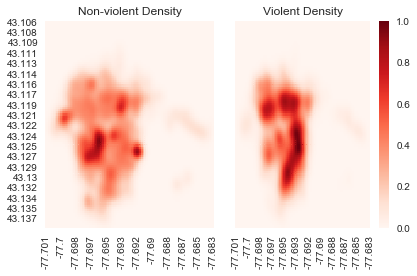

In [37]:
# Plot density estimates
xvals = np.round(np.linspace(xmin, xmax, 100), 3)
yvals = np.round(np.linspace(ymin, ymax, 100), 3)
scale = lambda x: (x - np.min(preds))/(np.max(preds)-np.min(preds))
scaled_preds = list(map(scale, preds))
fig, axn = plt.subplots(1, 2, sharex=True, sharey=True)
names = ["Non-violent Density", "Violent Density"]
for i, ax, name in zip([0, 1], axn.flat, names):
    sns.heatmap(scaled_preds[i], ax=ax,\
            cbar = i == 1,\
            vmin = 0,\
            vmax = 1,\
            cmap = "Reds")
    ax.set_title(name)
    ax.set_xticklabels(xvals)
    ax.set_yticklabels(yvals)
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', alpha=1, linewidth=1.0)
    ax.grid(b=True, which='minor', color='k', alpha=1, linewidth=0.5)
fig.tight_layout()
plt.savefig('output.png', dpi=300)